In [1]:
# with all production modes

import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections
import os

from collections import OrderedDict
import uproot
import pandas as pd

import scipy
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
sys.path.append('/storage/user/christiw/login-1/christiw/LLP/CMSSW_9_4_4/src/llp_analyzer/python/')
from helper import make_datacard, make_datacard_2sig, weight_calc
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot

import CMS_lumi, tdrstyle
a = tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

wH = 1
Z_MASS = 91.2


# donotdelete = []
print(sys.version)

Welcome to JupyROOT 6.22/02
3.6.8 (default, Apr  2 2020, 13:34:55) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


# Load ntuples

In [2]:
fpath =OrderedDict()
tree = OrderedDict()

prod = ['ggH']
decay = 'bbbb'

category = 0

mass = [15, 40, 55]

OLD_CTAU = np.array([100, 1000, 10000, 100000])#in mm


data_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/Data2018/v5/v86/normalized/'

fpath['data'] = data_path + 'Run2_displacedJetMuonNtupler_V1p17_Data2016_Data2017_Data2018-HighMET_goodLumi.root'
mc_path = {}
analyzer_version = 'v1/v86/'

analyzer_version = 'v1/v94/'
analyzer_version = 'v1/v95/'

mc_path['ggH'] = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_Fall17/'+analyzer_version+'/normalized/'
mc_path['ggH'] = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_1617/'+analyzer_version+'/normalized/'


for m in mass:
    for ct in OLD_CTAU:
        for p in prod:
            key = 'MC_'+p+'_'+str(m)+'_'+str(ct)                       
#             fpath[key] = mc_path[p]+p+'_HToSSTo'+decay+'_MH-125_MS-'+str(m)+'_ctau-'+str(ct)+'_TuneCP5_13TeV-powheg-pythia8_41530pb_weighted.root'
            fpath[key] = mc_path[p]+p+'_HToSSTo'+decay+'_MH-125_MS-'+str(m)+'_ctau-'+str(ct)+'_77450pb_weighted.root'




# ///storage/user/christiw/login-1/christiw/LLP/CMSSW_9_4_4/src/llp_analyzer/scripts/ggH_HToSSTobbbb_MH-125_MS-55_ctau-10000_77450pb_weighted.root
            
NEvents = {}
NEvents_genweight = {}
for k,v in fpath.items():
#     print(k,v)
    if 'data' in k:continue
    root_dir = uproot.open(v) 
    if not root_dir: 
        print(k, "zombie")
        continue
    tree[k] = root_dir['MuonSystem']
    NEvents[k] = root_dir['NEvents'][1]
    
    w = tree[k]["weight"].array()
    if not 'data' in k: 
        print(k, root_dir['NEvents']._fEntries)


MC_ggH_15_100 3995998.0
MC_ggH_15_1000 3936000.0
MC_ggH_15_10000 4116000.0
MC_ggH_15_100000 3963998.0
MC_ggH_40_100 3977381.0
MC_ggH_40_1000 3953000.0
MC_ggH_40_10000 3959998.0
MC_ggH_40_100000 4121483.0
MC_ggH_55_100 3931999.0
MC_ggH_55_1000 4066000.0
MC_ggH_55_10000 3975227.0
MC_ggH_55_100000 3987000.0


# load bdt

In [3]:
# make predictions for test data

import pickle
# model = pickle.load(open( 'bdt_flatten_noEvtSelection.pickle.dat', "rb" ))
# bdt_name = 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_XYspread_v12'
bdt_name = 'bdt_flatten_metfilter_me1112nohits_eta2p0_testsize0p2_noSpread_v2'


# model = pickle.load(open( bdt_name+'.pickle', "rb" ))


# nCsc with different hit vetoing

In [4]:

JET_PT_CUT = 10.0
MUON_PT_CUT = 20.0
N_RECHIT_CUT = 90
jetPt_cut = 50
tightid = False
ring_cut = 50
cut_based = True
cut_based_version = 'v4'

intime = True
DPHI_CUT = 1
weight = {}
weight_event = {}
weight_ctau = {}
lumiSec = {}
evtNum = {}
nCsc = {}
npv = {}
npu = {}
runNum = {}
nCsc_JetMuonVetoCluster0p4_Me1112Veto = {}
gLLP_csc = {}
cscClusterSize = {}
cscClusterTime = {}
nCscClusters = {}
selections_cluster = {}
sel_cluster = {}
sel_jetveto = {}
met_trigger = {}
met = {}
gLLP_beta = {}
jetPt = {}
jetPhi = {}
metPhi = {}
angle ={}
nLeptons = {}
genJetPt = {}
genJetPhi = {}
genMet = {}
genMetPhi = {}
pileupWeight = {}
gLLP_ctau = {}
npv = {}
nRechitClusters = {}
nJets = {}
nJets_50gev = {}
cscRechitClusterTimeDiff = {}
cscRechitCluster_match_gLLP = {}
higgsPtWeight = {}
cscRechitClusterXSpread = {}
cscRechitClusterYSpread = {}
cscRechitClusterXYSpread = {}
cscRechitClusterNStation = {}
cscRechitClusterAvgStation = {}
cscRechitClusterEtaPhiSpread = {}
cscRechitClusterPhiSpread = {}
cscRechitClusterEtaSpread = {}
cscRechitClusterX = {}
cscRechitClusterY = {}
cscRechitClusterZ = {}
cscRechitClusterPhi = {}
cscClusterJetVetoPt = {}
cscRechitClusterEta = {}
cscRechitClusterZSpread = {}
cscRechitClusterNStation10  = {}
cscRechitClusterAvgStation10 = {}
cscRechitClusterMaxStationRatio = {}
cscRechitClusterNChamber = {}
cscRechitClusterMet_dPhi = {}
jetMet_dPhiMin30 = {}
jetMet_dPhiMin = {}
dphiMet_cluster = {}
nRechits_sr = {}
jetMet_dPhiMin30_sr = {}
nCscRings = {}
nDtRings = {}
bdt_score = {}
a = {}
b = {}
c = {}
d = {}
sel_ev = {}
bdt_sel = {}
sf_facScaleUp = {}
sf_facScaleDown = {}
sf_renScaleUp = {}
sf_renScaleDown = {}
sf_facRenScaleUp = {}
sf_facRenScaleDown = {}
metSF = {}
legend = {}
runNum = {}
lumiSec = {}
evtNum = {}
ggZH_weight = {}
higgsEta = {}
higgsPt = {}
dphiMetHEM_cluster = {}
w_all = {}
w_EE = {}
EE_prefiring ={}
nJets = {}
metXYCorr = {}
cluster_index ='3'

for k in list(tree.keys()):
    if 'data' in k:continue
########### SELECTION: CLUSTERS ############
    T = tree[k]

    sel_rechitcluster = np.abs(T.array('cscRechitCluster' + cluster_index + 'Eta')) < 2.0
    
    me1112_veto = 0
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus11') <= me1112_veto)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus12') <= me1112_veto)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus11') <= me1112_veto)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus12') <= me1112_veto)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + '_match_MB1Seg_0p4') <= me1112_veto)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + '_match_RE12_0p4') <= me1112_veto)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + '_match_RB1_0p4') <= me1112_veto)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'TimeSpread') <= 20)
    if 'oot' in k:
        sel_rechitcluster = np.logical_and(sel_rechitcluster,  T.array('cscRechitCluster' + cluster_index + 'TimeTotal') < -12.5)
    else:
        sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'JetVetoPt') < JET_PT_CUT)

        sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'MuonVetoPt') < MUON_PT_CUT)
        sel_rechitcluster = np.logical_and(sel_rechitcluster, np.logical_and(T.array('cscRechitCluster' + cluster_index + 'TimeTotal') < 12.5, T.array('cscRechitCluster' + cluster_index + 'TimeTotal') > -5.0))
    sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'JetVetoPt') < JET_PT_CUT)
    sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'MuonVetoPt') < MUON_PT_CUT)
    if 'MC' in k:
        sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + '_match_gLLP_csc'))



########### SELECTION: JETS ############
    
    sel_jet = np.logical_and(T.array('jetPt') > jetPt_cut, np.abs(T.array('jetEta')) < 2.4 )
    hem = np.logical_and(T.array('jetEta') > -3, T.array('jetEta') < -1.3)
    hem = np.logical_and(hem, T.array('jetPhi') < -0.87)
    hem = np.logical_and(hem, T.array('jetPhi') > -1.57)



########### SELECTION: EVENTS ############

    sel_ev[k] = T.array('METNoMuTrigger')
    sel_ev[k] = np.logical_and(sel_ev[k] ,T.array('metXYCorr') >= 200)
#     sel_ev[k] = np.logical_and(sel_ev[k] ,T.array('EE_prefiring') ==1 )




    sel_ev[k]  = np.logical_and(sel_ev[k], T.array('category') == category)
    sel_ev[k] = np.logical_and(sel_ev[k] ,T.array('nLeptons') == 0)
    sel_ev[k] = np.logical_and(sel_ev[k],T.array('Flag2_all'))

    
    sel_ev[k] = np.logical_and(sel_ev[k] , sel_jet.sum()>=1)
    
    
    sel_ev[k]  = np.logical_and(sel_ev[k],sel_rechitcluster.sum() == 1)


    sel_ev[k] = np.logical_and(sel_ev[k], (T.array('nDtRings')+T.array('nCscRings'))<10)

    w = T.array('weight')*T.array('pileupWeight')*T.array('higgsPtWeight')*T.array('metSF')
    w_all[k] = np.sum(w)
    w_EE[k] = np.sum(w[T.array('EE_prefiring') ==1])
    
    if 'MC' in k:
        sel_ev[k] = np.logical_and(sel_ev[k], np.sum(T.array('gLLP_csc'),axis = 1) > 0)

########### BRANCHES ############

   ##### event variables ##### 
    
    gLLP_beta[k] = T.array('gLLP_beta')[sel_ev[k]]


    ##### bdt variables ####
    
    ##### bdt variables ####
    cscRechitClusterNStation10[k] = T.array('cscRechitCluster' + cluster_index + 'NStation10')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
    cscRechitClusterEta[k] = T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
    cscRechitClusterAvgStation10[k] = T.array('cscRechitCluster' + cluster_index + 'AvgStation10')[sel_rechitcluster][sel_ev[k]][:,0].flatten()

    
    if len(cscRechitClusterAvgStation10[k])>0:
        
        if cut_based:     
            if cut_based_version == 'v4':
                cond2 = np.logical_and(np.abs(cscRechitClusterAvgStation10[k])==2, np.abs(cscRechitClusterEta[k]) < 1.6)
                cond3 = np.logical_and(np.abs(cscRechitClusterAvgStation10[k])==3, np.abs(cscRechitClusterEta[k]) < 1.6)
                cond4 = np.logical_and(np.abs(cscRechitClusterAvgStation10[k])==4, np.abs(cscRechitClusterEta[k]) < 1.8)
                cond1 = np.logical_and(cscRechitClusterNStation10[k]==1, np.logical_or(np.logical_or(np.abs(cscRechitClusterAvgStation10[k])==1, cond2), np.logical_or(cond3, cond4)))
                cond2 = np.logical_and(cscRechitClusterNStation10[k] > 1, np.abs(cscRechitClusterEta[k]) < 1.9)
                bdt_sel[k] = np.logical_or(np.logical_or(cond1, cond2), np.logical_or(cond3, cond4))
            else:
                print("CUT BASED ERROR")
            if 'vr' in k:
                bdt_sel[k] = np.logical_not(bdt_sel[k])
                
        else:
            print('bdt based')
            if k == 'data_oot_sr':
                bdt_sel[k] = bdt_score[k] >= BDT_CUT
            elif 'vr' in k:
                bdt_sel[k] = bdt_score[k] < BDT_CUT            
            elif k == 'data':
                bdt_sel[k] = bdt_score[k] < BDT_CUT 
            else:
                bdt_sel[k] = bdt_score[k] >= BDT_CUT
        print("effiency",np.count_nonzero(bdt_sel[k])/len(bdt_sel[k]))

        dphiMet_cluster[k] = np.abs(T.array('cscRechitCluster' + cluster_index + 'MetXYCorr_dPhi'))[sel_rechitcluster][sel_ev[k]][:,0].flatten()[bdt_sel[k]]



        jetMet_dPhiMin30[k] = T.array('jetMet_dPhiMin')[sel_ev[k]][bdt_sel[k]]
        if 'data' in k:metSF[k]= np.ones(dphiMet_cluster[k].shape, dtype=bool)
        else: metSF[k] = np.abs(T.array('metSF'))[sel_ev[k]][bdt_sel[k]]


        higgsPt[k] = T.array('gHiggsPt')[sel_ev[k]][bdt_sel[k]]
        higgsEta[k] = T.array('gHiggsEta')[sel_ev[k]][bdt_sel[k]]

        weight[k] = (T.array('weight')*T.array('pileupWeight')*T.array('higgsPtWeight')*T.array('metSF'))[sel_ev[k]][bdt_sel[k]]
        EE_prefiring[k] = T.array('EE_prefiring')[sel_ev[k]][bdt_sel[k]]
        metXYCorr[k] = T.array('metXYCorr')[sel_ev[k]][bdt_sel[k]]
        nJets[k] = np.array(sel_jet.sum())[sel_ev[k]][bdt_sel[k]]

        cscClusterSize[k] =  T.array('cscRechitCluster' + cluster_index + 'Size')[sel_rechitcluster][sel_ev[k]][bdt_sel[k]]
        nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] = cscClusterSize[k][:,0]
        lumiSec[k] = T.array('lumiSec')[sel_ev[k]][bdt_sel[k]]
        runNum[k] = T.array('runNum')[sel_ev[k]][bdt_sel[k]]
        evtNum[k] = T.array('evtNum')[sel_ev[k]][bdt_sel[k]]
#         print(np.sum(weight[k]),np.sum(weight[k]*ggZH_weight[k]))
        
    else:
        dphiMet_cluster[k] = np.abs(T.array('cscRechitCluster' + cluster_index + 'Met_dPhi'))[sel_rechitcluster][sel_ev[k]][:,0].flatten()
        weight[k] = (T.array('weight')*T.array('pileupWeight')*T.array('higgsPtWeight'))[sel_ev[k]]
        if 'data' in k:weight[k] = np.ones(weight[k].shape, dtype=bool)
        cscClusterSize[k] =  T.array('cscRechitCluster' + cluster_index + 'Size')[sel_rechitcluster][sel_ev[k]]
        nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] = cscClusterSize[k][:,0]
        if 'data' in k:metSF[k]= np.ones(dphiMet_cluster[k].shape, dtype=bool)
        else: metSF[k] = np.abs(T.array('metSF'))[sel_ev[k]]
        lumiSec[k] = T.array('lumiSec')[sel_ev[k]]
        runNum[k] = T.array('runNum')[sel_ev[k]]
        evtNum[k] = T.array('evtNum')[sel_ev[k]]
        print("no BDT applied")

effiency 0.8270944741532977
effiency 0.9138095238095238
effiency 0.9065155807365439
effiency 0.898876404494382
effiency 0.6818181818181818
effiency 0.8911095796002757
effiency 0.9151014274981217
effiency 0.879746835443038
no BDT applied
effiency 0.8212209302325582
effiency 0.9250814332247557
effiency 0.9498069498069498


In [37]:
a = tdrstyle.setTDRStyle()



Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Info in <TCanvas::Print>: png file /storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/EE_prefiring/MC_ggH_15_100_dphiMet_cluster.png has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/EE_prefiring/MC_ggH_15_100_dphiMet_cluster.C has been generated
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_out_ratio
Info in <TCanvas::Print>: png file /storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/EE_prefiring/MC_ggH_15_1000_dphiMet_cluster.png has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots

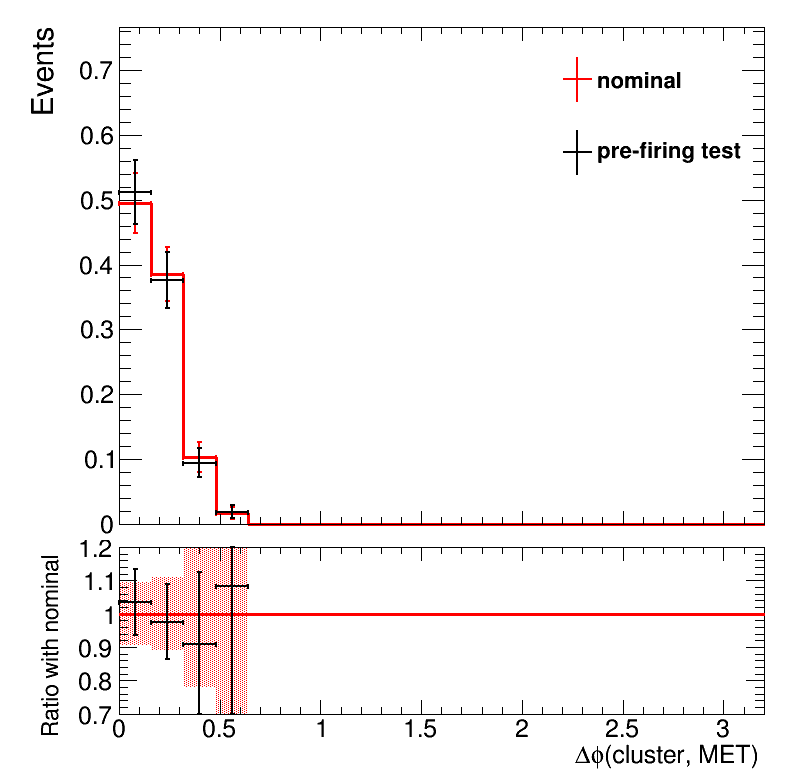

In [41]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot




leg = rt.TLegend(0.5,0.7,0.85,0.9)
leg.SetTextSize(0.025)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
legend={
    'ggh': 'ggH',
    'VBFH': 'ggH + VBF',
    'allProd': 'All production modes'
}

c = rt.TCanvas('c','c', 800, 800)
# Plotting ncsc
start_t = time.time()

rt.gStyle.SetOptFit(1011)
# ctaus_m = ctaus/1000
h = {}
var = dphiMet_cluster
var = metXYCorr
# var = nJets
var = [dphiMet_cluster, cscClusterSize, metXYCorr, nJets]
name = ['dphiMet_cluster', 'cscClusterSize', 'met','njets']
bins = [[20,0,3.2],  [0, 50, 70, 100, 150, 250, 500,1000,1500,2000],list(np.arange(0,500,50))+[750,1000],[10,0,10]]

xaxis  = ['#Delta#phi(cluster, MET)', 'N_{rechits}','MET [GeV]', 'Number of Jets']
for j in range(len(var)):
    if not j == 0:continue
    for i, k in enumerate(tree.keys()):
    
        if k == 'MC_ggH_55_100':continue
        if len(var[j][k])==0:continue
#         if not k == 'MC_ggH_15_1000':continue
        if j <=1: cond = np.logical_and(metXYCorr[k]>=200, nJets[k]>=1)
        elif j == 3:cond = metXYCorr[k]>=200
        else: cond = metXYCorr[k]>=0
#         h[k] = create_TH1D(np.abs(var[k][cond]),axis_title=['dphi', 'Events'],binning = [10,0,10])
        h[k] = create_TH1D(np.abs(var[j][k][cond]),axis_title=[xaxis[j], 'Events'],binning = bins[j], weights = weight[k][cond])
        h[k+'EE'] = create_TH1D(np.abs(var[j][k])[np.logical_and(cond, EE_prefiring[k]==1)],axis_title=[xaxis[j], 'Events'],binning = bins[j],  weights = weight[k][np.logical_and(cond, EE_prefiring[k]==1)])
        
#         hm = create_TH1D(np.ones(np.count_nonzero( var[j][k]>=130)),axis_title=['', ''],binning = [1,0,2],  weights = weight[k][var[j][k][:,0]>=130])
#         hm = create_TH1D(np.ones(np.count_nonzero( np.abs(var[j][k])<0.75)),axis_title=['', ''],binning = [1,0,2],  weights = weight[k][np.abs(var[j][k])<0.75])

#         hb = create_TH1D(np.ones((len(weight[k]))),axis_title=['', ''],binning = [1,0,2], weights =  weight[k])

#         pEff = rt.TEfficiency(hm, hb)
#         temp = np.logical_and(np.logical_and(cond, var[j][k][:,0]>=130), EE_prefiring[k]==1)
#         temp = np.logical_and(np.logical_and(cond, np.abs(var[j][k])<0.75), EE_prefiring[k]==1)

#         hm_ee = create_TH1D(np.ones(np.count_nonzero(temp)),axis_title=['', ''],binning = [1,0,2],  weights = weight[k][temp])
#         hb_ee = create_TH1D(np.ones((np.count_nonzero(np.logical_and(cond, EE_prefiring[k]==1)))),axis_title=['', ''],binning = [1,0,2], weights =  weight[k][np.logical_and(cond, EE_prefiring[k]==1)])

#         pEff_ee = rt.TEfficiency(hm_ee, hb_ee)
        
#         print(k, pEff.GetEfficiency(1), pEff.GetEfficiencyErrorUp(1), pEff.GetEfficiencyErrorLow(1))
#         print(k, pEff_ee.GetEfficiency(1), pEff_ee.GetEfficiencyErrorUp(1), pEff_ee.GetEfficiencyErrorLow(1))
#         denom = max(pEff.GetEfficiencyErrorUp(1), pEff.GetEfficiencyErrorLow(1))/pEff.GetEfficiency(1)
#         nom = max(pEff_ee.GetEfficiencyErrorUp(1), pEff_ee.GetEfficiencyErrorLow(1))/pEff_ee.GetEfficiency(1)


#         print(k, round((pEff_ee.GetEfficiency(1)/pEff.GetEfficiency(1)-1)*100, 2), round((nom**2+denom**2)**0.5*pEff_ee.GetEfficiency(1)/pEff.GetEfficiency(1)*100,2))
#         if j == 0:
#             print(k, np.count_nonzero(np.abs(var[j][k][cond])<0.75)/len(np.abs(var[j][k][cond])))
#             print(k, np.count_nonzero(np.abs(var[j][k][np.logical_and(cond, EE_prefiring[k]==1)])<0.75)/len(var[j][k][np.logical_and(cond, EE_prefiring[k]==1)]))
#         elif j ==1:
#             print(k, np.count_nonzero(np.abs(var[j][k][cond])>=130)/len(np.abs(var[j][k][cond])))
#             print(k, np.count_nonzero(np.abs(var[j][k][np.logical_and(cond, EE_prefiring[k]==1)])>=130)/len(var[j][k][np.logical_and(cond, EE_prefiring[k]==1)]))
#         elif j == 2:
#             print(k, np.count_nonzero(np.abs(var[j][k][cond])>=200)/len(np.abs(var[j][k][cond])))
#             print(k, np.count_nonzero(np.abs(var[j][k][np.logical_and(cond, EE_prefiring[k]==1)])>=200)/len(var[j][k][np.logical_and(cond, EE_prefiring[k]==1)]))
#         else:
#             print(k, np.count_nonzero(np.abs(var[j][k][cond])>=1)/len(np.abs(var[j][k][cond])))
#             print(k, np.count_nonzero(np.abs(var[j][k][np.logical_and(cond, EE_prefiring[k]==1)])>=1)/len(var[j][k][np.logical_and(cond, EE_prefiring[k]==1)]))


        h[k].SetLineColor(std_color_list[1])
        h[k+'EE'].SetLineColor(std_color_list[0])

        h[k].SetLineWidth(3)
        h[k].Scale(1./h[k].Integral())

        h[k+'EE'].Scale(1./h[k+'EE'].Integral())

        h[k].GetXaxis().SetTitleOffset(1)

#         h[k].DrawNormalized("same")
#         h[k+'EE'].DrawNormalized("same")

        c = make_ratio_plot([h[k], h[k+'EE']], fit = False, logy=False, in_tags = ["nominal","pre-firing test"],ratio_index = 0,\
                            ratio_bounds = [0.7,1.2], draw_opt = ['E1','E1']) 


        c.Draw()
        output_dir = '/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/EE_prefiring/'


        if not os.path.isdir(output_dir):os.makedirs(output_dir)
        c.SaveAs(output_dir+k+'_'+name[j]+'.png')
        c.SaveAs(output_dir+k+'_'+name[j]+'.C')




# signal yield summary table

In [7]:

ctaus = [ '100', '1000','10000','100000' ]
# ctaus = ['500', '1000', '10000', '100000', '1000000']

# ctaus = [ '10000','100000' ]

# ctaus = [  '1000' ]


# ctaus = [  '10000','100000' ]


BR = 0.01
N_RECHIT_CUT = 130
DPHI_CUT = 0.75



var = dphiMet_cluster
# DPHI_CUT = 0.6      
# var = jetMet_dPhiMin30
for N_RECHIT_CUT in np.arange(60,220,10):
    if not N_RECHIT_CUT==130:continue
    total_sig = 0
    for m in mass:
#         if not m == 55:continue
        signal_rate = []
        unc_rate = []
        signal_unc = []
        denominator = []
        for ct in ctaus:   
#             if not ct == '1000':continue
            signal = 0
            total = 0
            sig_unc = 0
            shape_unc_temp = 0
            ctf = int(ct)
            if ctf < OLD_CTAU[0]:
                old_ctau_temp = np.array([OLD_CTAU[0]])
            else:
                for j, ct0 in enumerate(OLD_CTAU):
                    if ct0 == ctf: 
                        old_ctau_temp = np.array([int(ctf)])
                        break

                    elif ct0 > ctf:
                        old_ctau_temp = np.array([OLD_CTAU[j-1], OLD_CTAU[j]])
                        old_ctau_temp = np.array([OLD_CTAU[j]])
                        break
                    if j == len(OLD_CTAU)-1: 
                        old_ctau_temp = np.array([OLD_CTAU[j]])
#             print(ct,old_ctau_temp)

            weight_sum = 0
            weight_len = 0
            for j,ct0 in enumerate(old_ctau_temp):
#                 if VBFH: prods = ['ggH', 'VBFH']
#                 else: prods = ['ggH']
                prods = ['ggH']
                for p in prods:
#                 for p in ['','LL','QQ','NuNu']:
#                     production = 'ttH'
                    k = 'MC_'+p+'_'+str(m)+'_'+str(ct0)+''
#                         k = 'MC_'+'ggZH'+'_'+str(m)+'_'+str(ct0)+p


                    T = tree[k]
                    if np.count_nonzero(sel_ev[k]) == 0: continue
                    gLLP_ctau = np.sum(T.array('gLLP_ctau'), axis = 1)[sel_ev[k]][bdt_sel[k]]
                    if len(gLLP_ctau) == 0: continue
                    weight_ctau = weight_calc(gLLP_ctau, float(ct)/10, old_ctau_temp/10) # convert everything to cm
                    w = weight[k]

                    a = np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] >= N_RECHIT_CUT, np.abs(var[k]) >= DPHI_CUT)
                    b = np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] < N_RECHIT_CUT, np.abs(var[k]) >= DPHI_CUT)
                    c = np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] < N_RECHIT_CUT, np.abs(var[k]) < DPHI_CUT)
                    d = np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] >= N_RECHIT_CUT, np.abs(var[k]) < DPHI_CUT)
                    cond = d
        

                    signal += np.sum(w[cond])
                    sig_unc +=np.sum(w[cond]*w[cond])
                    total += w_EE[k]
#                     shape_unc_temp = (shape_unc_temp**2+np.sum(w[cond]*shape_unc[cond])**2)**0.5


            signal_rate.append(signal)
            signal_unc.append(sig_unc**0.5)
            unc_rate.append(shape_unc_temp)
            denominator.append(total)
        signal_rate = np.array(signal_rate)
        unc_rate = np.array(unc_rate)
        signal_unc = np.array(signal_unc)
        denominator = np.array(denominator)
#         print(N_RECHIT_CUT, '\t', signal_rate[0]*BR)
#         print(m,'GeV &', ' & '.join(map(str, [round(num,2) for num in signal_rate*BR])),'\\\\')
#         print(m,'GeV &', ' '.join(map(str, [round(num,4) for num in signal_rate*BR])),'\\\\')


#         print(m, '\t', '\t'.join(map(str, [round(num,2) for num in signal_unc*BR])))
#         print(m, '\t', '\t'.join(map(str, [round(num,3) for num in signal_rate*BR])))
    
        print(m, '\t', '\t'.join(map(str, [round(num,7) for num in signal_rate*BR])))



#         print(m, '\t', '\t'.join(map(str, [round(num,2) for num in signal_unc/signal_rate])))


#         print(m, '\t'.join(map(str,[round(num,2) for num in unc_rate*BR]))) #signal mc relative uncertainty
        total_sig += np.sum(signal_rate)
# print(total_sig*BR)

#     print(m, '\t'.join(map(str,unc_rate/signal_rate))) #signal mc relative uncertainty



15 	 2.2525442	7.8590684	1.8157993	0.2312498
40 	 0.0720348	6.1964845	5.436847	0.555422
55 	 0.0	2.7031368	6.6447688	1.0710379


In [ ]:
15 	 0.0157823	0.0021215	0.0011596	0.0010274
40 	 0.0248379	0.0032727	0.0016081	0.0009395
55 	 nan	0.003328	0.001609	0.0011458